In [2]:
import copy
import json
import os
import numpy as np
import kernel
import configuration
import calibration
from matplotlib import pyplot as plt

In [3]:
def test_data(c_path, w_path, e_path, json_path, offset=1, printing=True): 
    descriptors = np.loadtxt(c_path)
    weights = np.loadtxt(w_path)
    e_ave = np.loadtxt(e_path)[0]
    with open(json_path, 'r') as u_conf:
            user_config = json.load(u_conf)

    # make a list of the allowed qs
    qs = np.arange(1, user_config['nr_modi']+1) * np.pi / user_config['cutoff']

    # read in data and save parameters for calibration comparison
    (nc_new, ni_new, lat, configurations) = calibration.load_data(user_config, offset)

    config = configurations[0]
    
    if printing:
        for key, value in user_config.items():
            if type(value) != list:
                print(f'{key:>15}: {value:<15}')
            else:
                print(f'{key:>15}: {value[0]:<15}')
                print(f'{"sigma":>15}: {value[1]:<15}')

    nc_old = int(weights.size / 64)
    ni_old = 64

    kern = kernel.Kernel(*user_config['kernel'])

    config.init_nn(user_config['cutoff'], lat)
    config.init_descriptor(qs)

    E, F_reg = kern.predict(qs, config, descriptors, weights, e_ave)
    
    delta_F = F_reg - config.forces
    F_mean = np.mean(np.linalg.norm(delta_F, axis=1))
    F_var = np.var(np.linalg.norm(delta_F, axis=1))

    signs_reg = np.sign(F_reg)
    signs_ana = np.sign(config.forces)
    sign_diff = signs_reg - signs_ana
    
    if printing:
        print('\nPredicted values:')
        print(f'energy = {E}')
        print(f'forces = {F_reg[1]}\n')

        print('Values from Outcar:')
        print(f'energy = {config.energy}')
        print(f'forces = {config.forces[1]}')
        print('\nSign differences:', sign_diff[sign_diff != 0].size, 'out of', sign_diff.size)
        #print(sign_diff)


        print(f'Mean norm of difference:\n {F_mean} +- {F_var}')
        print(f'Relative to size of F:\n {F_mean / np.mean(np.linalg.norm(config.forces, axis=1))}')
    return(F_mean, F_var,  sign_diff[sign_diff != 0].size)



In [4]:
def float_to_str(nr: float):
    nr = float(nr)
    return str(nr).replace('.', '')

def min_sigma_of_axis(data, axis):
    return data[np.where(data[:, axis] == np.nanmin(data[:, axis]))][0]

def make_header(path, data, case):
    print(f'Minimize values in {case} from:')
    print(path)
    print(f'{"sigma":10}|{"mean force":10}|{"var force":10}|{"mean cos":10}|{"var cos":10}|{"energy":10}|')
    for i in range(1, 6):
        line = ""
        for val in min_sigma_of_axis(data, i):
            line += f'{val:10.6f}|'
        print(line)    
    
def plot4(data: np.array, max_n, title=""):
    fig, axs = plt.subplots(3, 2, figsize = (20, 12))
    fig.suptitle(title, fontsize=20)
    titles = ["force mean", "force variance", "mean $cos$", "var $cos$", "energy difference"]
    
    for i, ax in enumerate(axs.flatten()):
        ax.plot(data[:max_n, 0], data[:max_n, i+1])
        ax.grid()
        ax.set(xlabel="$\sigma$", title=titles[i])
        if i in (0, 1):
            ax.set_yscale('log')
        if i == 4:
            break
            

def analyze(n: int, min_sigma, max_sigma, modi, stepsize, max_n=-1):
    print(f'{"steps":10}={n:5}')
    print(f'{"min sigma":10}={min_sigma:5}')
    print(f'{"max sigma":10}={max_sigma:5}')
    print(f'{"grid":10}={abs(min_sigma - max_sigma)/n:5}')
    print(f'{"configs":10}={1000 / stepsize:5}')
    print(f'{"modi":10}={modi:5}\n')
    
    fit_path = f'test_data/fit_{n}_({float_to_str(min_sigma)}-{float_to_str(max_sigma)})_m{modi}_s{stepsize}.dat'
    fit = np.loadtxt(fit_path)
    make_header(fit_path, fit, 'fit')
    print("\n")

    pred_path = f'test_data/prediction_{n}_({float_to_str(min_sigma)}-{float_to_str(max_sigma)})_m{modi}_s{stepsize}.dat'
    prediction = np.loadtxt(pred_path)
    make_header(pred_path, prediction, 'prediction')
        
    plot4(fit, max_n, "Fitting")
    plot4(prediction, max_n, "Prediction")

# Linear Kernel

In [5]:
test_data('test_data/c_lin_10.out', 'test_data/w_lin_10.out', 'test_data/e_lin_10.out', 'test_data/lin_10.json')

        file_in: OUTCAR.21      
       file_out: test_data      
       stepsize: 1000           
         cutoff: 4              
        nr_modi: 10             
         lambda: 0.001          
         kernel: linear         
          sigma:                

Predicted values:
energy = -307.3937472587071
forces = [ 0.6930024  -0.21777951 -0.47929145]

Values from Outcar:
energy = -306.56723878
forces = [ 0.463753 -0.593154 -0.339427]

Sign differences: 28 out of 192
Mean norm of difference:
 0.49890646576586417 +- 0.04779279743831686
Relative to size of F:
 0.3724728151966518


(0.49890646576586417, 0.04779279743831686, 28)

# Gaussian Kernel

In [6]:
test_data('test_data/c_gaus_10.out', 'test_data/w_gaus_10.out', 'test_data/e_gaus_10.out', 'test_data/gaus_10.json')     

        file_in: OUTCAR.21      
       file_out: test_data      
       stepsize: 1000           
         cutoff: 4              
        nr_modi: 10             
         lambda: 0.001          
         kernel: gaussian       
          sigma: 1              

Predicted values:
energy = -307.9103162022497
forces = [-32.09861649  -5.30471067 -13.71075235]

Values from Outcar:
energy = -306.56723878
forces = [ 0.463753 -0.593154 -0.339427]

Sign differences: 92 out of 192
Mean norm of difference:
 28.491481832043167 +- 1205.438889367551
Relative to size of F:
 21.271126303834496


(28.491481832043167, 1205.438889367551, 92)

# Bigger sigma

In [7]:
test_data('data/calibration_C.out', 'data/calibration_w.out', 'data/calibration_E.out', 'user_config.json', 0)

        file_in: OUTCAR.21      
       file_out: data           
       stepsize: 50             
         cutoff: 4              
        nr_modi: 10             
         lambda: 1e-12          
         kernel: gaussian       
          sigma: 12.0           

Predicted values:
energy = -307.7168734652534
forces = [ 0.36377524 -0.12468137 -0.49767049]

Values from Outcar:
energy = -306.41169589
forces = [ 0.354149 -0.521376 -0.257292]

Sign differences: 27 out of 192
Mean norm of difference:
 0.6731069935508774 +- 0.0999309624354076
Relative to size of F:
 0.48965012355013476


(0.6731069935508774, 0.0999309624354076, 27)

# Analyzing the influence of $\sigma$ in correspondence to nr of modi
## 10 modi

steps     =   25
min sigma =    0
max sigma =   10
grid      =  0.4
configs   = 10.0
modi      =   10

Minimize values in fit from:
test_data/fit_25_(00-100)_m10_s100.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  7.083336|  0.474746|  1.387334|  0.917142|  0.022892|  0.004079|
  2.083341|  0.712368|  0.659335|  0.756060|  0.164388|  0.004063|
  0.000010|  1.167267|  2.437140|  0.354695|  0.322066|  0.000000|
  7.083336|  0.474746|  1.387334|  0.917142|  0.022892|  0.004079|
  0.416676|  1.333680| 19.198600|  0.676611|  0.144085|  0.000000|


Minimize values in prediction from:
test_data/prediction_25_(00-100)_m10_s100.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  7.083336|  0.376273|  0.063871|  0.920235|  0.016115|  0.003309|
  0.000010|  1.000000|  0.000000|       nan|       nan|  0.002355|
  0.833342|781.915820|3898992.433026|  0.067478|  0.328799|  0.121394|
  7.500002|  0.395088|  0.062281|  0.916660|  0.015353|  0.003624|
  9.

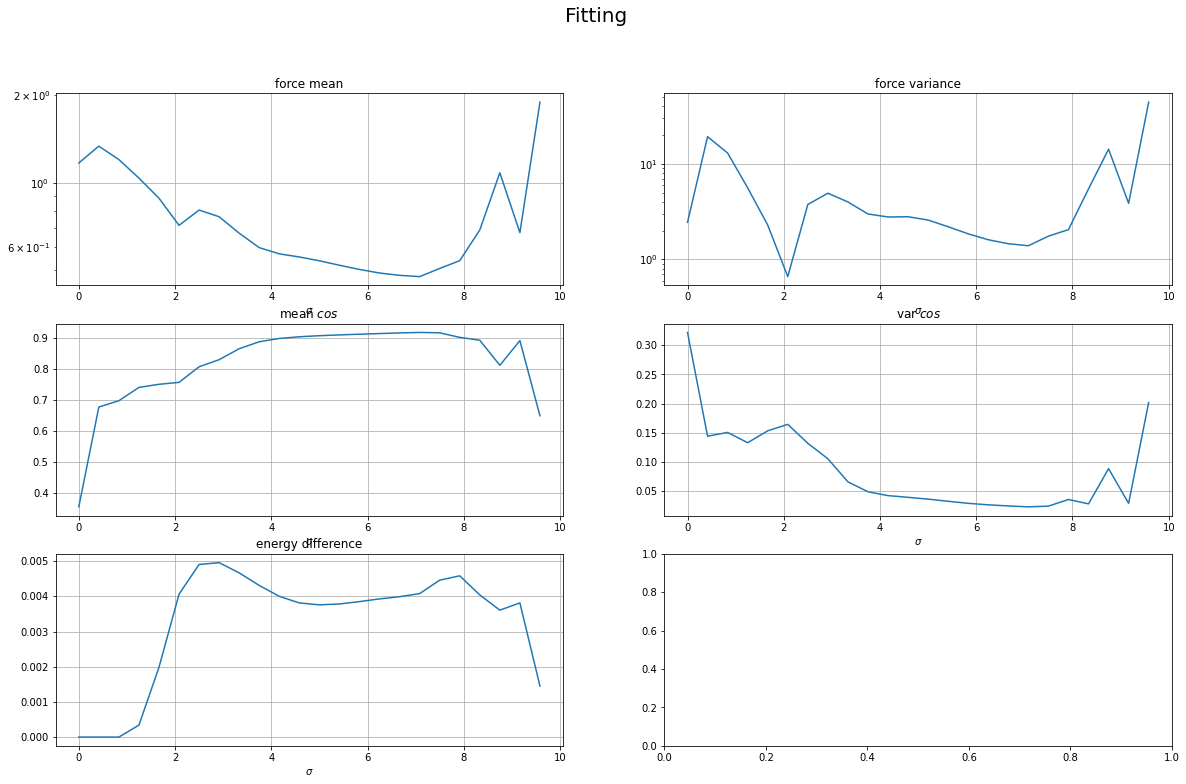

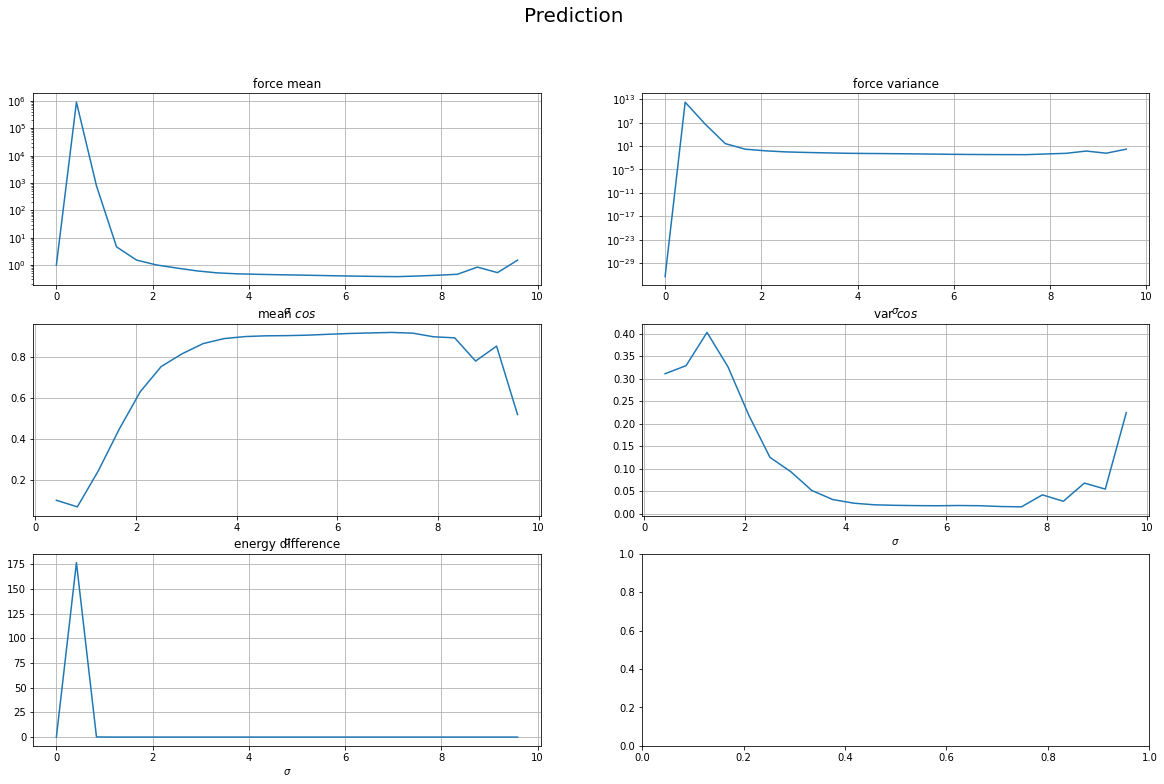

In [8]:
analyze(25, 0, 10, 10, 100)

steps     =   10
min sigma =    0
max sigma =    1
grid      =  0.1
configs   = 10.0
modi      =   10

Minimize values in fit from:
test_data/fit_10_(00-10)_m10_s100.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  0.111120|  1.000000|  0.000000|  0.307274|  0.280703|  0.000000|
  0.111120|  1.000000|  0.000000|  0.307274|  0.280703|  0.000000|
  0.111120|  1.000000|  0.000000|  0.307274|  0.280703|  0.000000|
  1.000000|  1.118335|  8.997468|  0.723572|  0.119685|  0.000011|
  0.111120|  1.000000|  0.000000|  0.307274|  0.280703|  0.000000|


Minimize values in prediction from:
test_data/prediction_10_(00-10)_m10_s100.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  0.000010|  1.000000|  0.000000|       nan|       nan|  0.002355|
  0.000010|  1.000000|  0.000000|       nan|       nan|  0.002355|
  0.333340|3070047.240816|43631073427522.507812| -0.002548|  0.336071|1267.499540|
  0.666670|191110.111274|244077473198.764832|  0.051013|  0.2

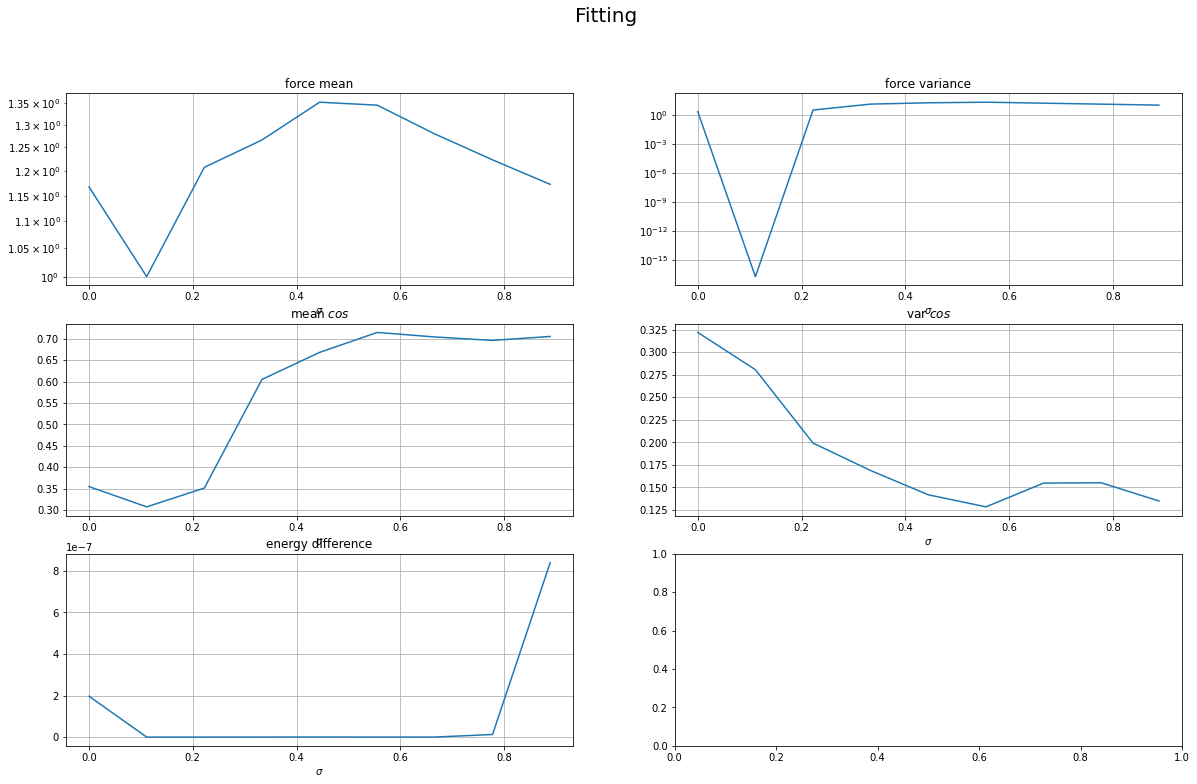

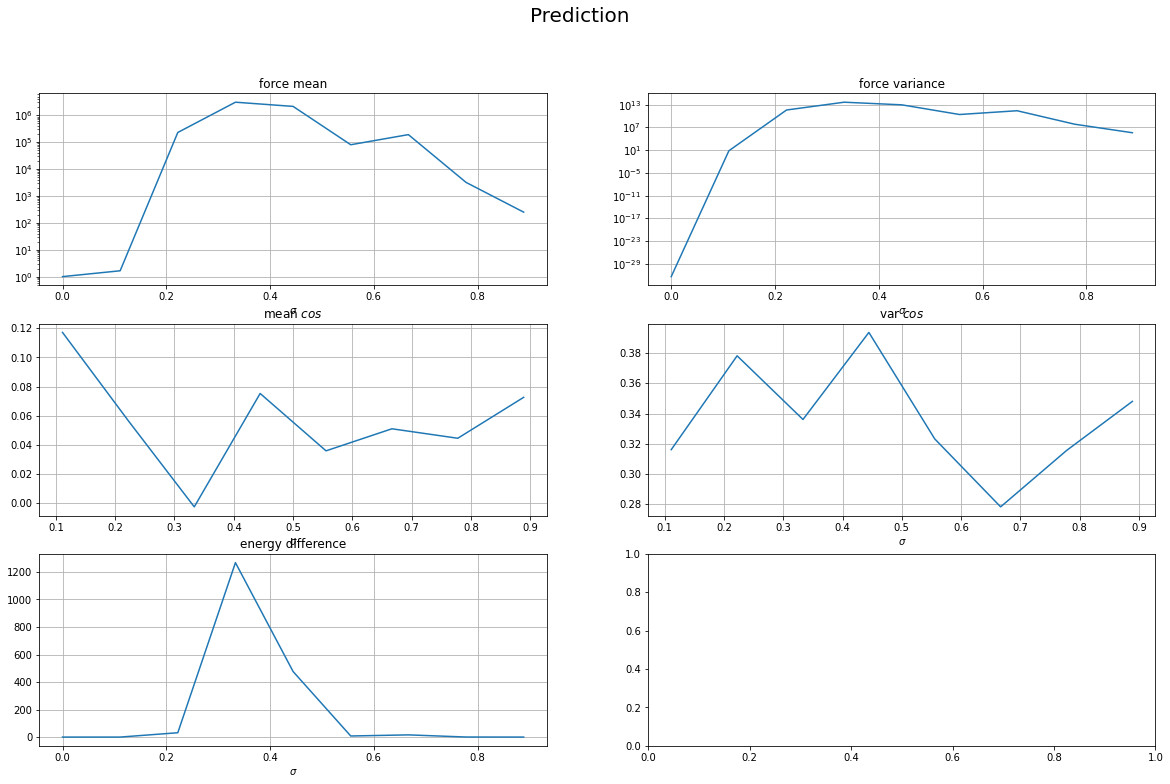

In [10]:
analyze(10, 0, 1, 10, 100)

steps     =   20
min sigma =    0
max sigma =   10
grid      =  0.5
configs   = 10.0
modi      =    2

Minimize values in fit from:
test_data/fit_20_(00-100)_m2_s100.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  0.000010|  1.084260|  1.703590|  0.465646|  0.202668|  0.000000|
  0.000010|  1.084260|  1.703590|  0.465646|  0.202668|  0.000000|
  1.052641|  3.410278|228.187172|  0.075639|  0.326688|  0.000105|
  0.000010|  1.084260|  1.703590|  0.465646|  0.202668|  0.000000|
  0.000010|  1.084260|  1.703590|  0.465646|  0.202668|  0.000000|


Minimize values in prediction from:
test_data/prediction_20_(00-100)_m2_s100.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  4.736847|  0.923545|  0.110009|  0.433152|  0.246947|  0.001326|
  0.000010|  1.000000|  0.000000|       nan|       nan|  0.002355|
  0.526325|  5.620653| 60.682826|  0.044289|  0.390584|  0.011222|
  5.263163|  0.943292|  0.140616|  0.428035|  0.232788|  0.001545|
  1.052641

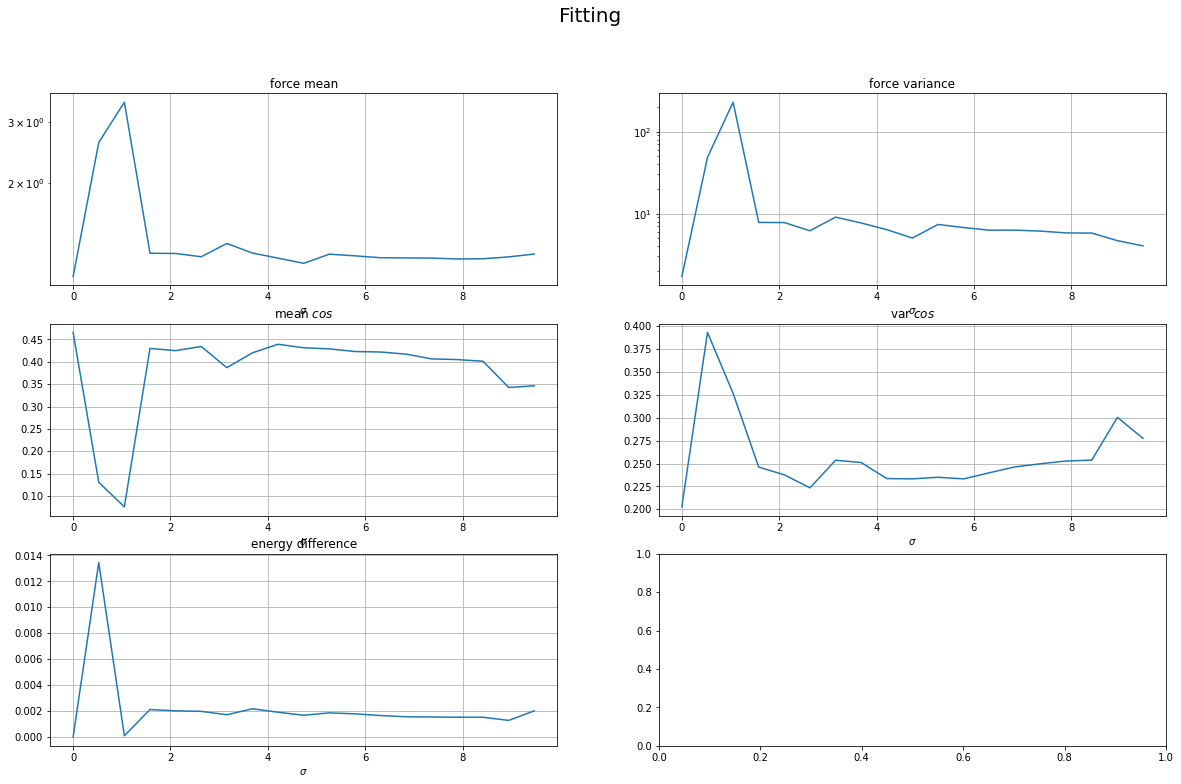

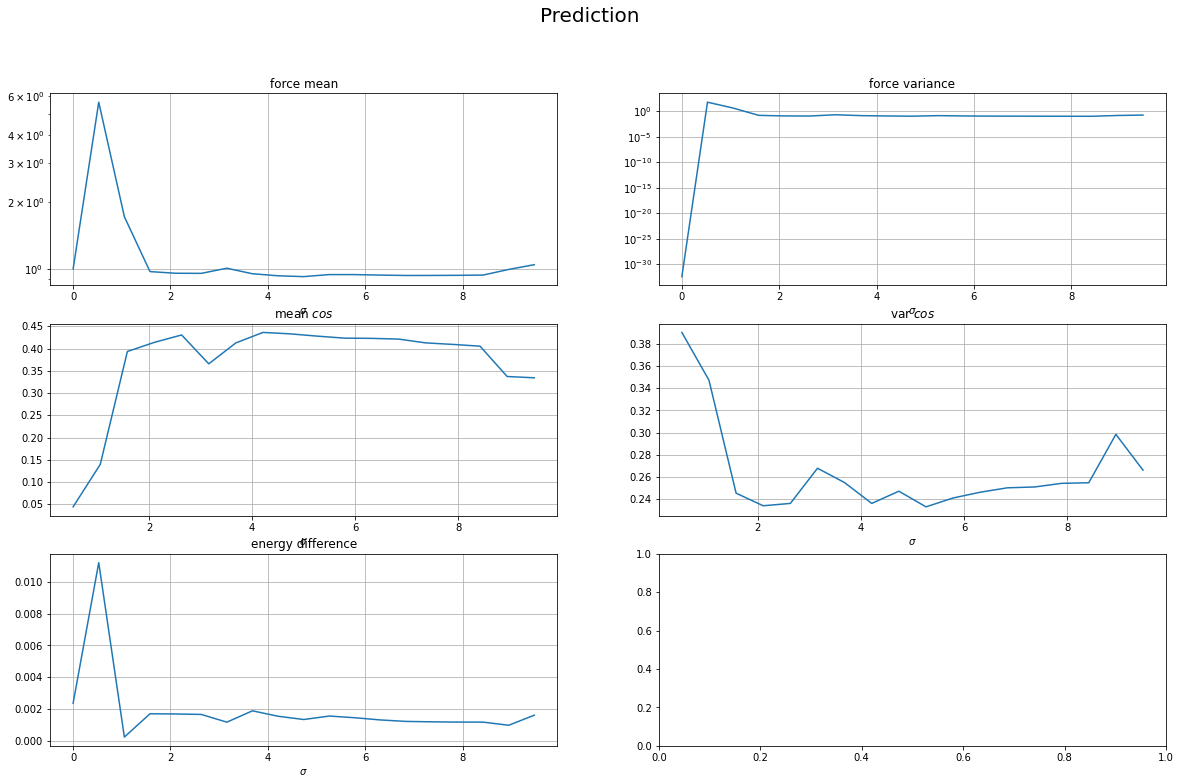

In [16]:
analyze(20, 0, 10, 2, 100)

steps     =   20
min sigma =    0
max sigma =   10
grid      =  0.5
configs   = 10.0
modi      =    4

Minimize values in fit from:
test_data/fit_20_(00-100)_m4_s100.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  3.157902|  0.667069|  2.855818|  0.846438|  0.079527|  0.004009|
  3.157902|  0.667069|  2.855818|  0.846438|  0.079527|  0.004009|
  5.263163|  9.134690|197.031661|  0.112086|  0.397612|  0.010764|
  1.052641|  0.752296|  6.567746|  0.879262|  0.036684|  0.002274|
  0.000010|  1.347795|  7.063524|  0.449641|  0.304615|  0.000000|


Minimize values in prediction from:
test_data/prediction_20_(00-100)_m4_s100.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  3.157902|  0.495362|  0.171327|  0.865815|  0.046386|  0.002906|
  0.000010|  1.000000|  0.000000|       nan|       nan|  0.002355|
  5.263163|  7.604926| 63.809285|  0.143098|  0.387486|  0.012168|
  3.157902|  0.495362|  0.171327|  0.865815|  0.046386|  0.002906|
  2.105271

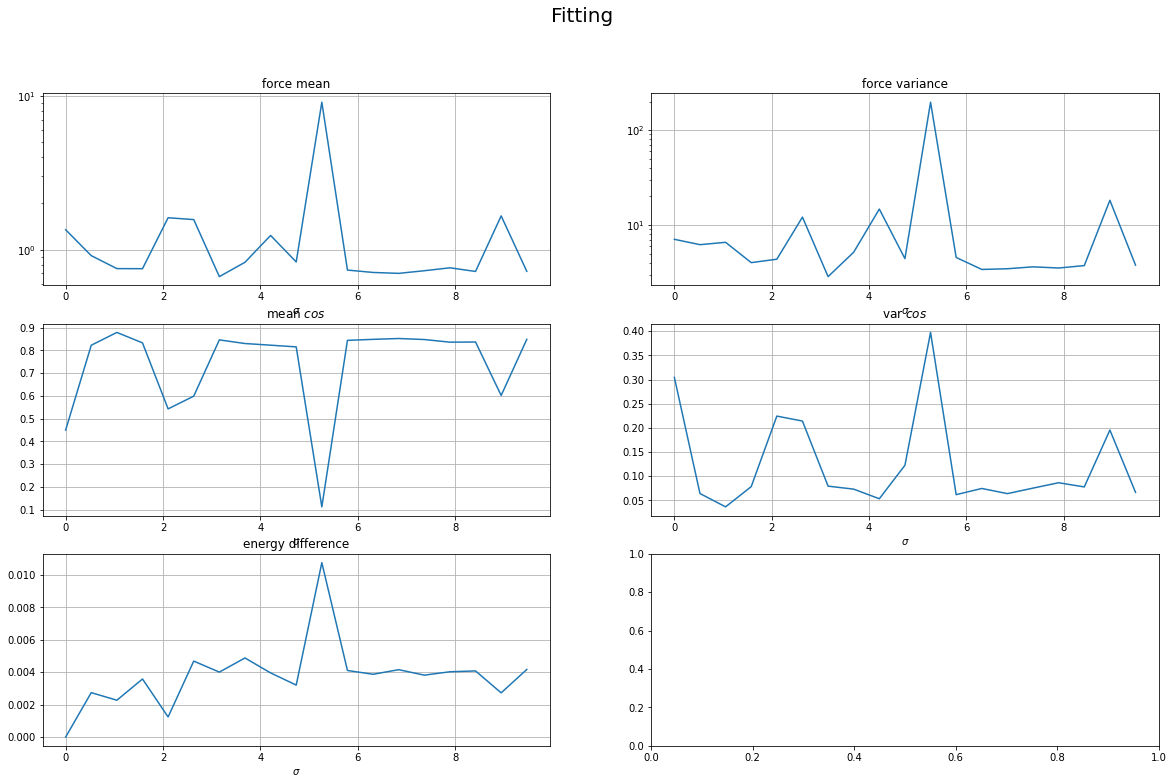

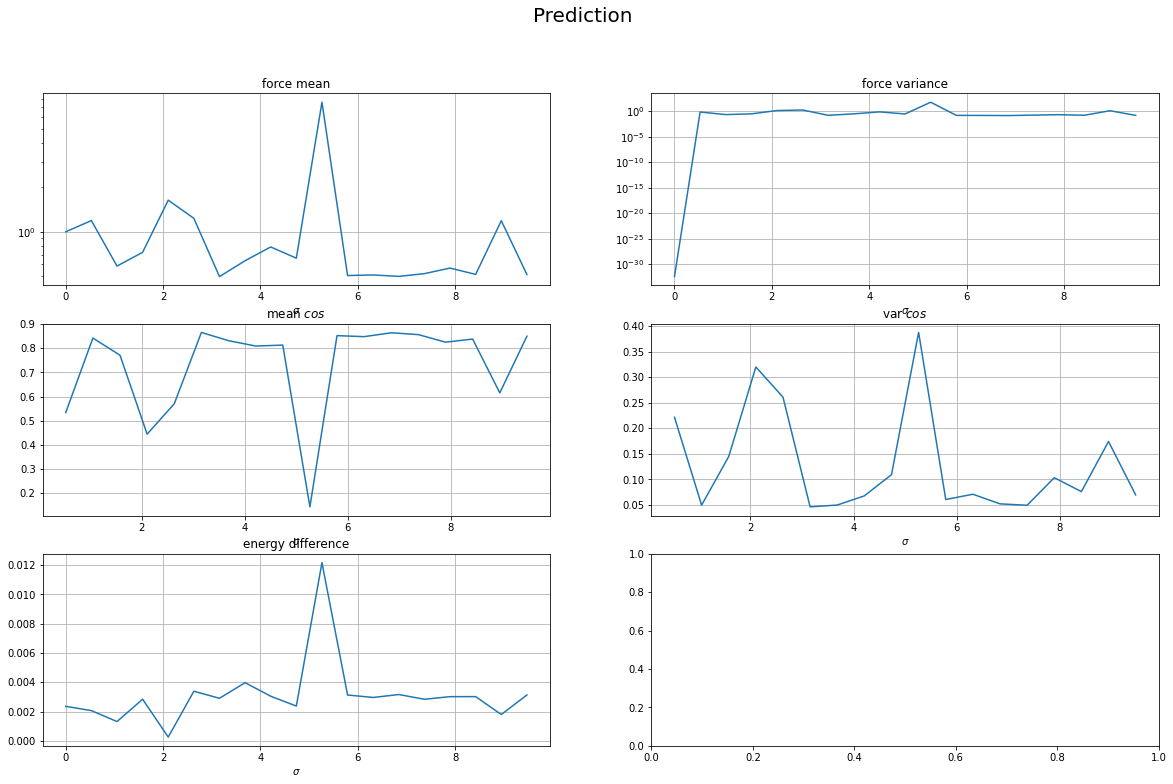

In [17]:
analyze(20, 0, 10, 4, 100)

# Analyzing the influence of the nr of configurations
## Learning on 20 configurations

steps     =   20
min sigma =    0
max sigma =   12
grid      =  0.6
configs   = 20.0
modi      =   10

Minimize values in fit from:
test_data/fit_20_(00-120)_m10_s50.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  4.421059|  0.540775|  2.784374|  0.911576|  0.028541|  0.003394|
  1.894745|  0.628218|  0.517804|  0.855099|  0.036160|  0.003130|
  6.315794|  6.761983|298.478032|  0.119325|  0.356686|  0.004753|
  5.052637|  0.545893|  3.015476|  0.912985|  0.026075|  0.003470|
  0.631588|  1.312013| 13.665248|  0.618278|  0.160441|  0.000000|


Minimize values in prediction from:
test_data/prediction_20_(00-120)_m10_s50.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  5.052637|  0.388560|  0.081494|  0.919174|  0.015053|  0.002966|
  0.000010|  1.000000|  0.000000|       nan|       nan|  0.001977|
  0.631588|416654.417616|1142601201703.342285|  0.036693|  0.294237| 23.950194|
  4.421059|  0.395950|  0.079609|  0.920681|  0.014477|  0.00278

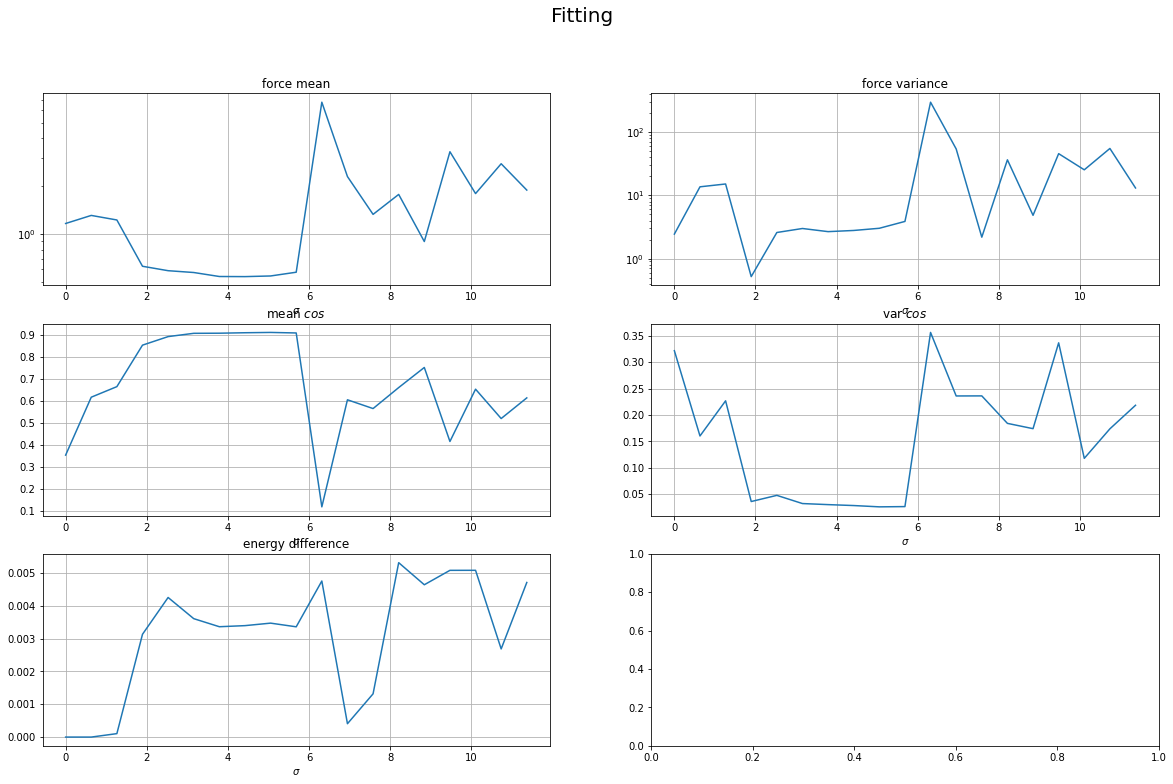

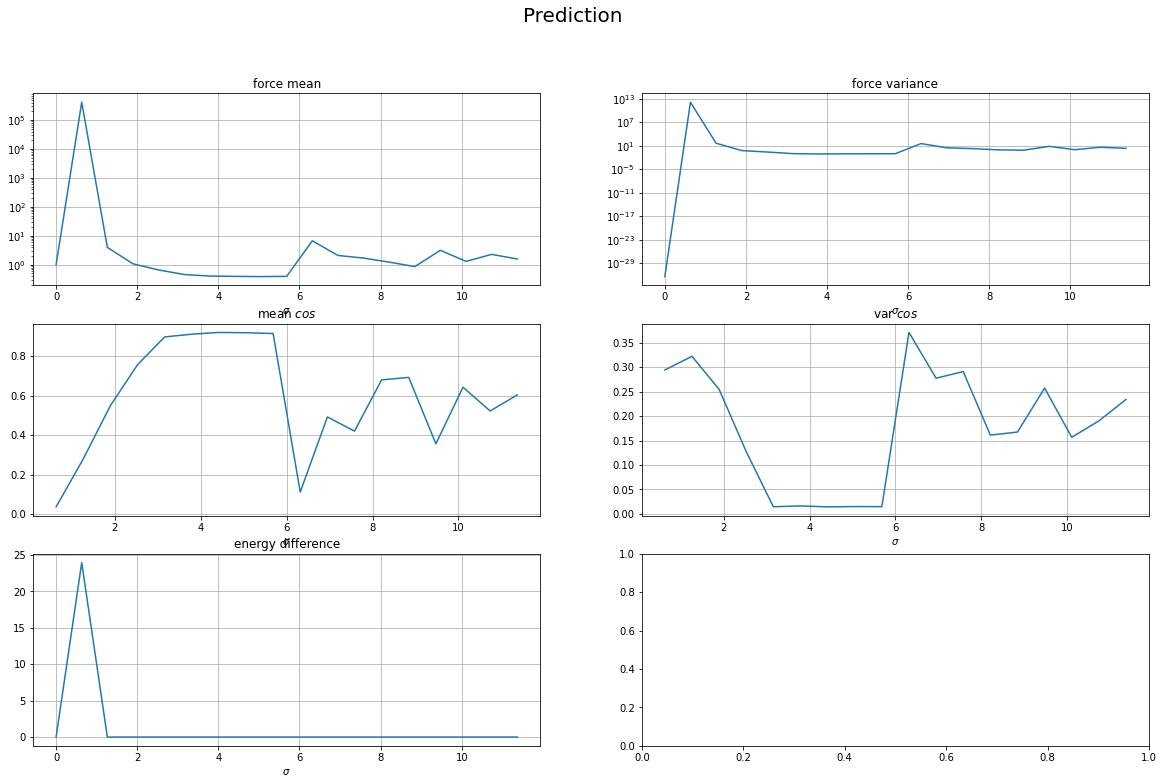

In [12]:
analyze(20, 0, 12, 10, 50)

## Learning on 40 configurations

steps     =   20
min sigma =    0
max sigma =   12
grid      =  0.6
configs   = 40.0
modi      =   10

Minimize values in fit from:
test_data/fit_20_(00-120)_m10_s25.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  4.421059|  0.505705|  2.491476|  0.929829|  0.014125|  0.003726|
  8.842108|  0.756923|  1.578613|  0.795721|  0.114765|  0.005189|
 10.105265|  5.669783| 75.691731|  0.162889|  0.383286|  0.005617|
  4.421059|  0.505705|  2.491476|  0.929829|  0.014125|  0.003726|
  0.000010|  1.167267|  2.437139|  0.354695|  0.322066|  0.000000|


Minimize values in prediction from:
test_data/prediction_20_(00-120)_m10_s25.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  4.421059|  0.392697|  0.081805|  0.915967|  0.011551|  0.003211|
  0.000010|  1.000000|  0.000000|       nan|       nan|  0.002185|
  0.631588|362.137519|601587.438966|  0.083915|  0.294750|  0.039853|
  4.421059|  0.392697|  0.081805|  0.915967|  0.011551|  0.003211|
  1.263

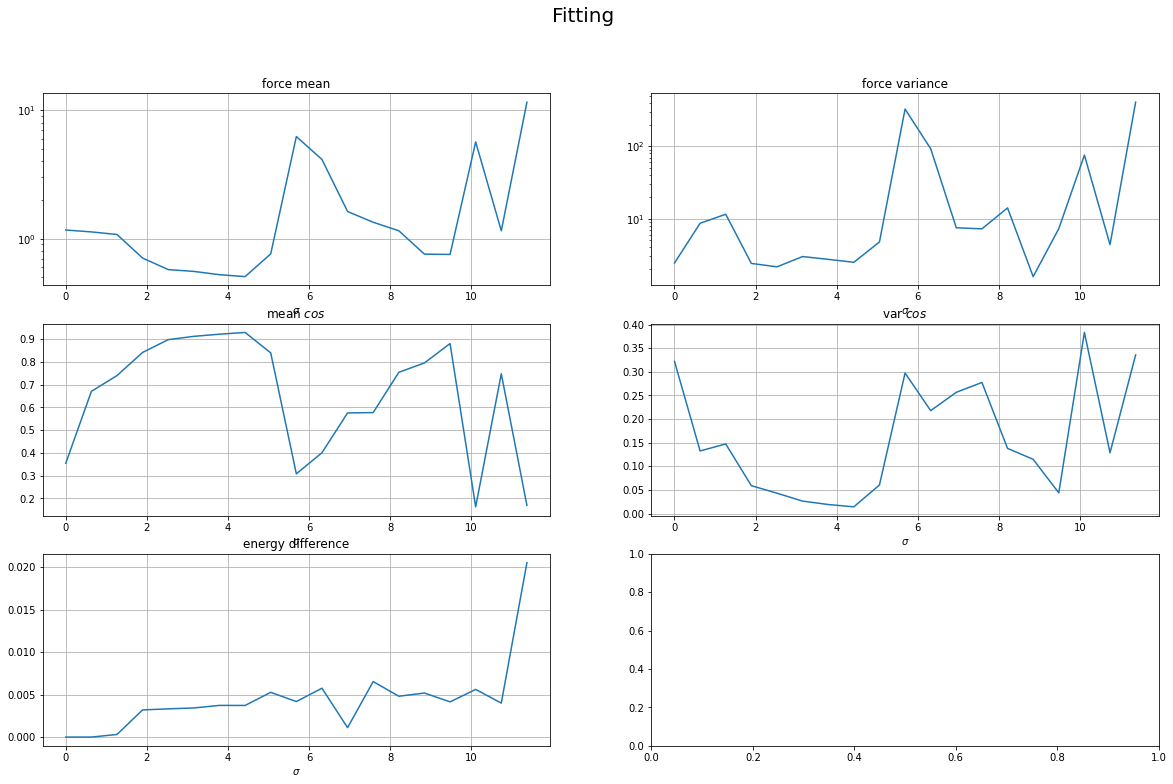

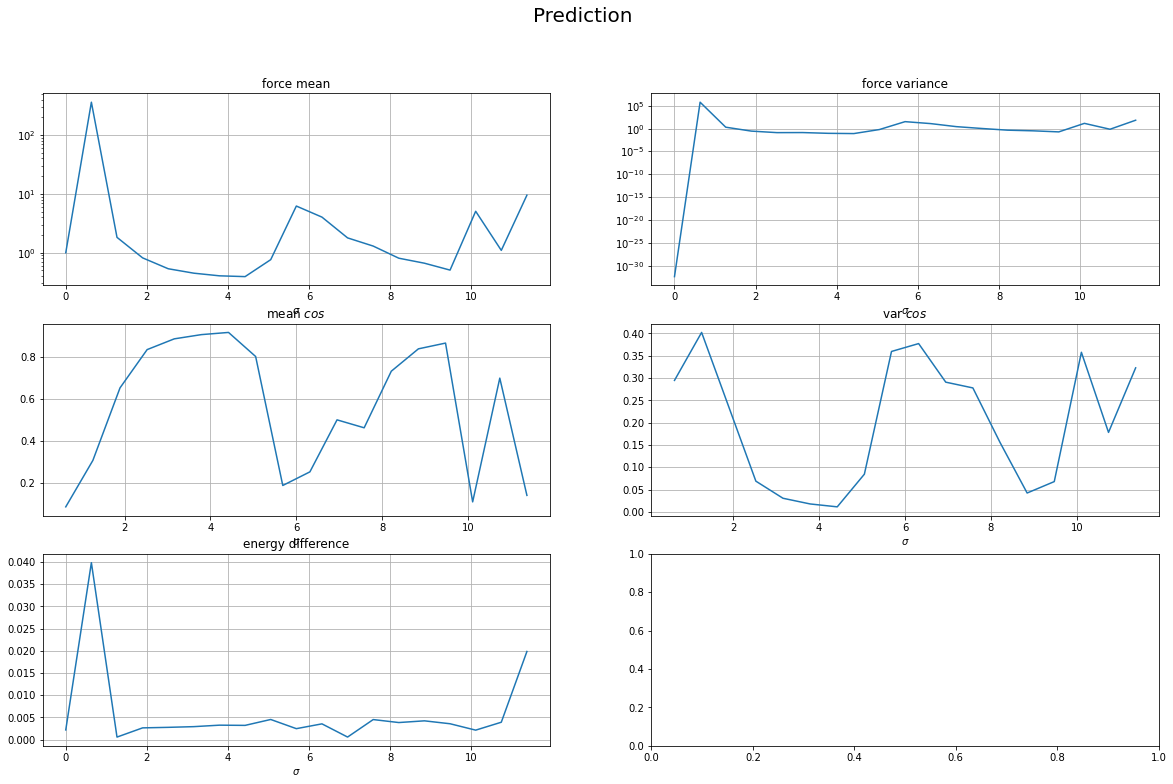

In [13]:
analyze(20, 0, 12, 10, 25)

## Learning on 7 configurations

steps     =   20
min sigma =    0
max sigma =   10
grid      =  0.5
configs   =6.666666666666667
modi      =   10

Minimize values in fit from:
test_data/fit_20_(00-100)_m10_s150.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  4.736847|  0.452462|  0.592550|  0.895550|  0.033266|  0.003036|
  4.210532|  0.469289|  0.571656|  0.889282|  0.035495|  0.003085|
  0.000010|  1.167267|  2.437136|  0.354695|  0.322066|  0.000000|
  8.421054|  0.471036|  1.375312|  0.921539|  0.019853|  0.003263|
  0.526325|  1.230153|  8.222246|  0.584925|  0.191195|  0.000000|


Minimize values in prediction from:
test_data/prediction_20_(00-100)_m10_s150.dat
sigma     |mean force|var force |mean cos  |var cos   |energy    |
  7.368424|  0.403901|  0.097263|  0.905525|  0.022685|  0.002295|
  0.000010|  1.000000|  0.000000|       nan|       nan|  0.001643|
  0.526325|1008987.254164|4241227868771.056641| -0.018766|  0.364565| 73.125026|
  6.315793|  0.408101|  0.095751|  0.905951|  0.0

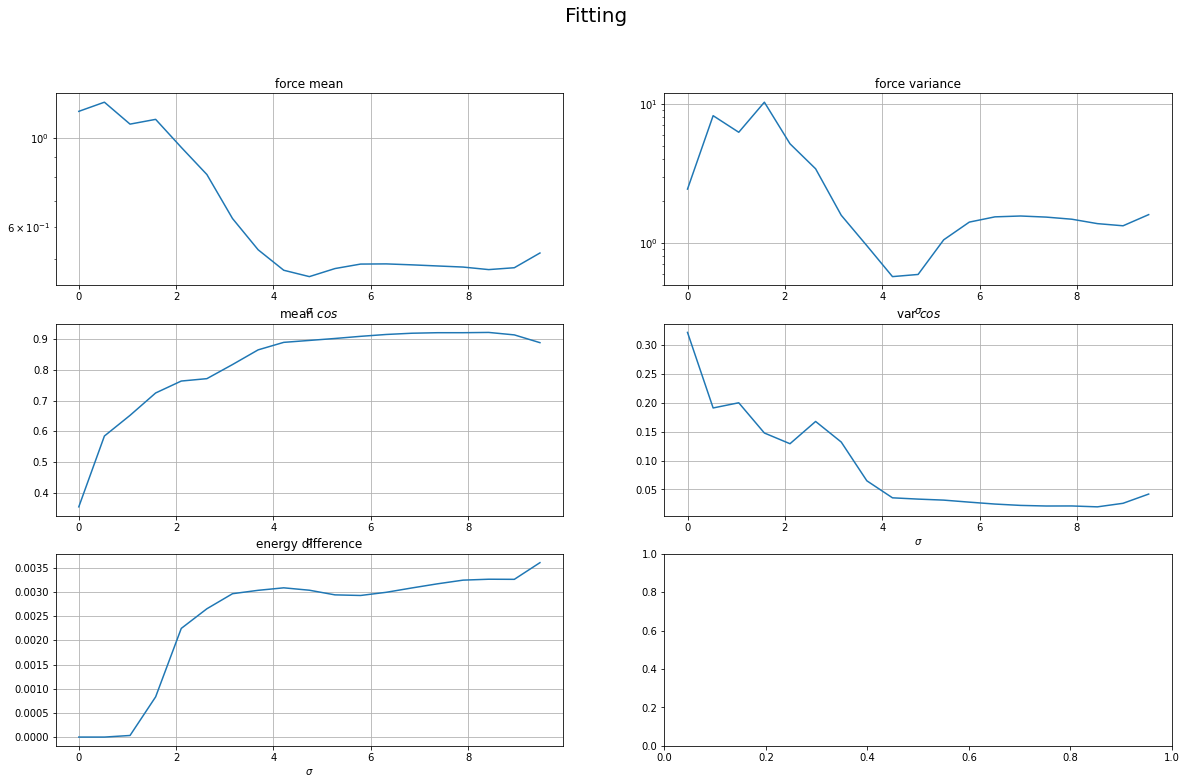

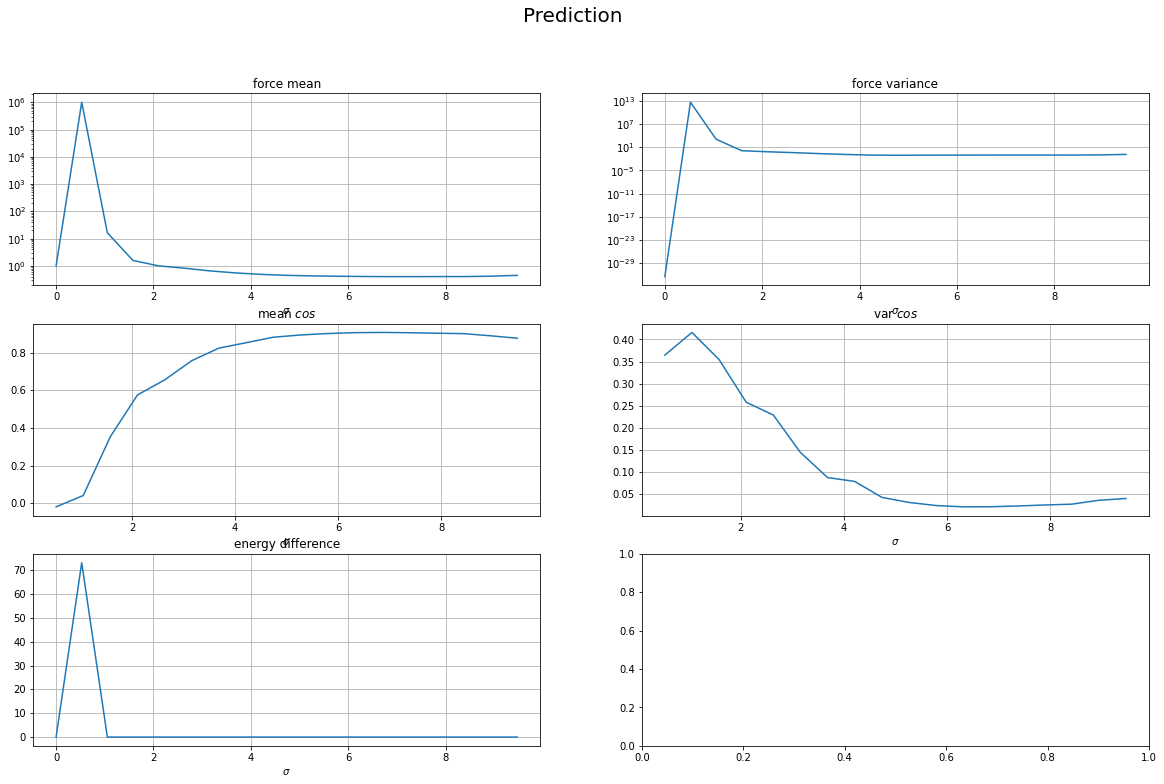

In [15]:
analyze(20, 0, 10, 10, 150)